In [2]:
import sys 
sys.path.append('..')

%load_ext autoreload
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, Grayscale
from torchvision.datasets import MNIST, CIFAR10 
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit

%autoreload 2
from networks import *
from utils import *
from losses import *
from landscape import *
from datasets import *

import matplotlib.pyplot as plt
import progressbar
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Training Setup

In [3]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=300
dims_latent = 32                            
learning_rate=1e-3
batch_size=32                                        
device=set_device("cuda", 0)
train_size=0.00108

# Losses
l2loss    = nn.MSELoss(reduction="sum")
awi1D     = AWLoss1D(reduction="sum", std=1e-4, store_filters=True, alpha=0.02)
awi2D     = AWLoss2D(reduction="sum", std=1e-4, store_filters=True, alpha=0.02)

Cuda installed! Running on GPU 0 GeForce RTX 2080 Ti!


In [8]:
# Training loop
def train_model(model, optimizer, criterion, train_loader, nepochs=150, vis_frequency=10):
    print("\n\nTraining started ...")
    all_loss, all_mse, all_kl = [], [], []
    with progressbar.ProgressBar(max_value=nepochs) as bar:    
        for epoch in range(nepochs):
            epoch_loss, epoch_kl = train(model, train_loader, optimizer, criterion, device=device)
            epoch_mse = validate(model, train_loader, nn.MSELoss(reduction="mean"), device=device)
            all_loss.append(epoch_loss.item())
            all_mse.append(epoch_mse.item())
            all_kl.append(epoch_kl.item())
            bar.update(epoch)
                

            # Metric logs and plots
            log = {"epoch": epoch, "train_mse":epoch_mse.item(), "train_loss": epoch_loss.item(), "train_kl_loss": epoch_kl.item()}
            if epoch % vis_frequency == 0 or epoch==nepochs-1:
                print("\n", log)
                idx = random.randint(0, len(trainds))
                idx=-1
                X = trainds[idx][0].unsqueeze(0).to(device)
                recon = model(X)
                if isinstance(recon, tuple): recon = recon[0] # in case model returns more than one output, recon must be the first
                
                f = criterion(recon, X)
                try:
                    v, T = criterion.v_all[0], criterion.T_arr
                    print(" argidx T, v: ",torch.argmax(torch.abs(T)).item(), torch.argmax(torch.abs(v)).item())
                except:
                    pass

                plot_grad_flow(model.named_parameters())

                fig, axs = plt.subplots(2,3)
                axs[0, 0].imshow(recon[0, 0].cpu().detach().numpy(), cmap="gray", vmin=0., vmax=1.)
                axs[0, 0].set_title("recon")

                axs[0, 1].imshow(X[0, 0].cpu().detach().numpy(), cmap="gray", vmin=0., vmax=1.)
                axs[0, 1].set_title("orig")

                axs[0, 2].imshow(X[0, 0].cpu().detach().numpy() - recon[0, 0].cpu().detach().numpy(), vmin=-0.5, vmax=0.5)
                axs[0, 2].set_title("diff")

                try:
                    axs[1, 0].plot(v.flatten().detach().cpu().numpy())
                    axs[1, 0].plot(T.flatten().detach().cpu().numpy(), "--")
                    axs[1, 0].set_title("T vs v")
                    axs[1, 0].set_ylim(None, 1.1)

                    axs[1, 1].plot((T.flatten() - v.flatten()).detach().cpu().numpy())
                    axs[1, 1].set_title("T - v")
                    axs[1, 1].set_ylim(None, 1.1)
                    plt.show()
                except:
                    pass

                fig, axs = plt.subplots(1,3, figsize=(7, 3))
                axs[0].plot(all_loss, label="loss")
                axs[0].legend()
                axs[0].set_xlabel("epoch")
                axs[1].plot(all_mse, label="mse")
                axs[1].legend()
                axs[1].set_xlabel("epoch")
                axs[2].plot(all_kl, label="kl_loss")
                axs[2].legend()
                axs[2].set_xlabel("epoch")
                plt.show()

# MNIST Example

## Datasets and Dataloaders

In [5]:
# Datasets and dataloaders
train_transform = Compose([
    Resize(28),
    ToTensor(),
])

ds = MNIST("../", download=True, train=True, transform=train_transform)
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=42).split(ds.data, ds.targets)
train_idx, valid_idx = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

X_train, y_train = ds.data[train_idx] / 255., ds.targets[train_idx]
trainds = TensorDataset(X_train.unsqueeze(1).float(), y_train.float())

train_loader = DataLoader(trainds, batch_size=batch_size, shuffle=True, num_workers=4)

X = trainds[0][0].unsqueeze(0).to(device) # a sample for check ups
print("Trainable Images:", len(trainds))
print(X.shape, X.min().item(), X.max().item())


Trainable Images: 64
torch.Size([1, 1, 28, 28]) 0.0 0.9960784316062927


# L2-Norm

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 300) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.22430601716041565, 'train_loss': 5773.10791015625, 'train_kl_loss': 0.0}


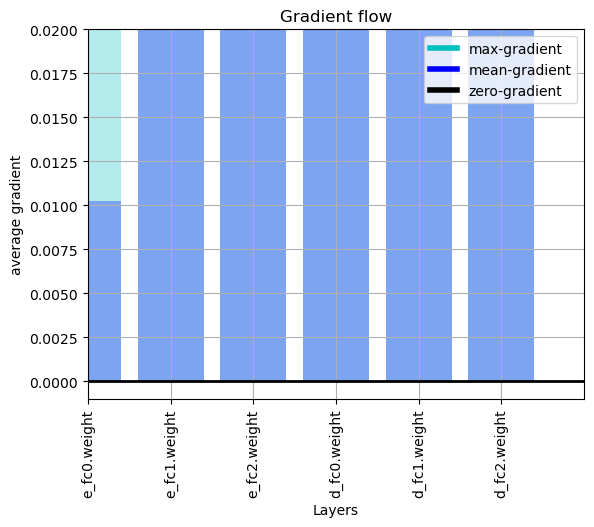

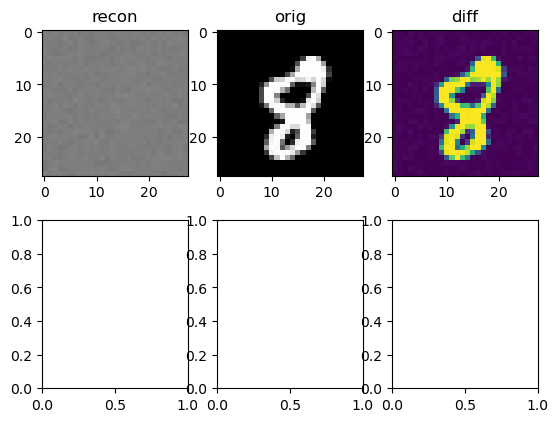

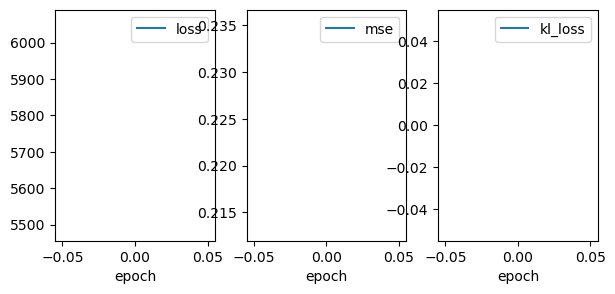

 33% (100 of 300) |#######               | Elapsed Time: 0:00:32 ETA:   0:01:15


 {'epoch': 100, 'train_mse': 0.023123444989323616, 'train_loss': 592.6259765625, 'train_kl_loss': 0.0}


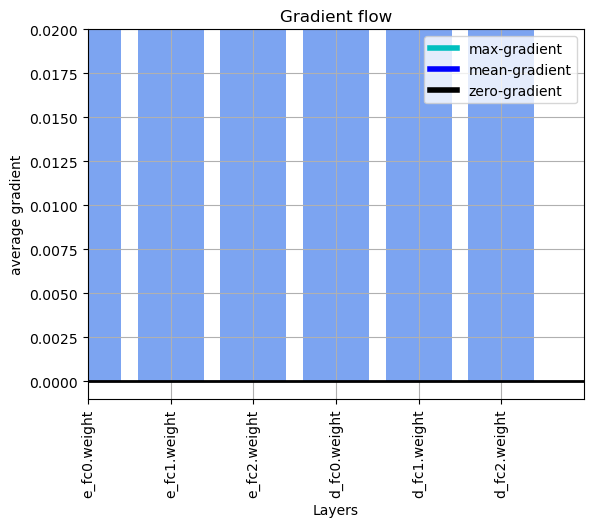

Traceback (most recent call last):
  File "/home/dekape/miniconda3/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/home/dekape/miniconda3/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/dekape/miniconda3/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


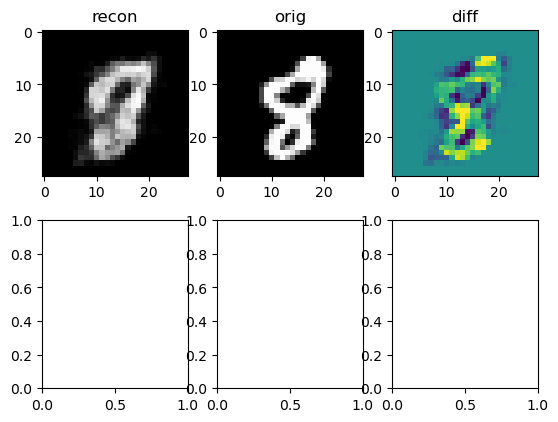

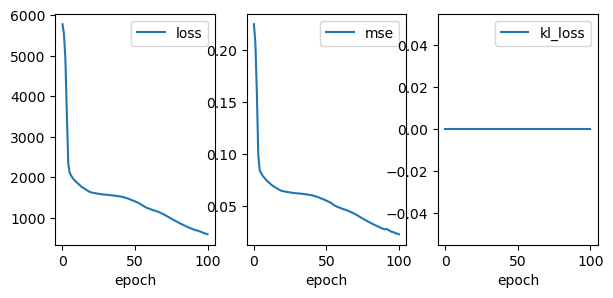

 66% (200 of 300) |##############        | Elapsed Time: 0:01:04 ETA:   0:00:30


 {'epoch': 200, 'train_mse': 0.004125548992305994, 'train_loss': 104.58938598632812, 'train_kl_loss': 0.0}


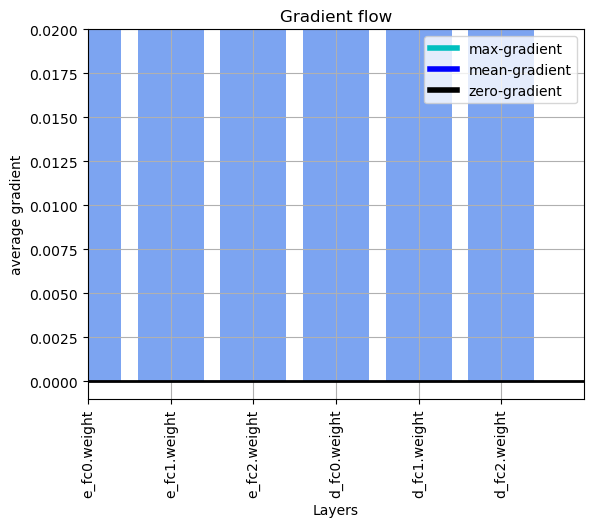

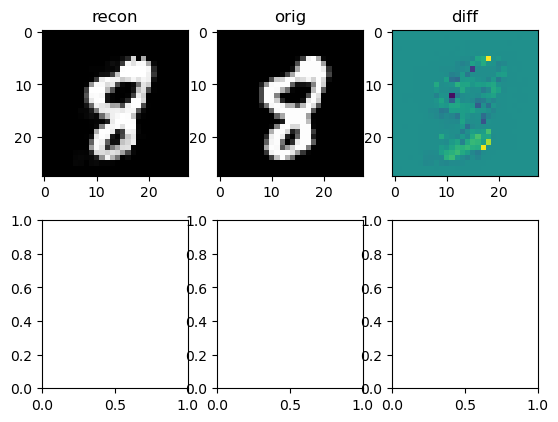

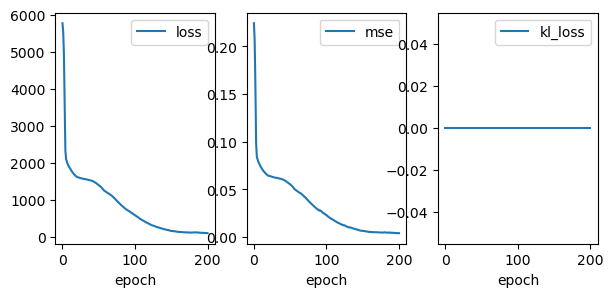

 99% (299 of 300) |##################### | Elapsed Time: 0:01:35 ETA:   0:00:00


 {'epoch': 299, 'train_mse': 0.0029574260115623474, 'train_loss': 74.16754150390625, 'train_kl_loss': 0.0}


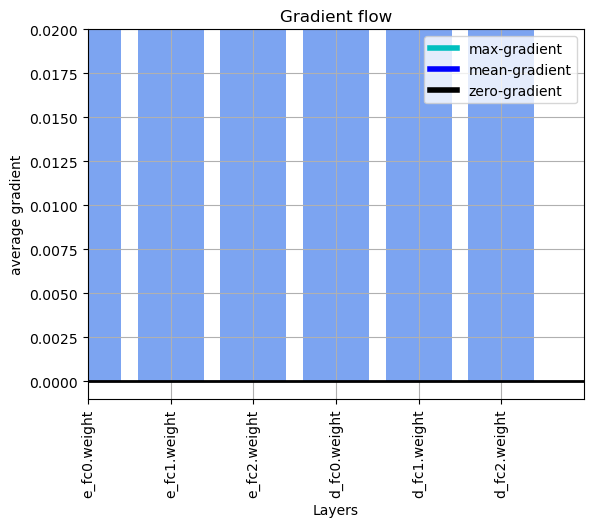

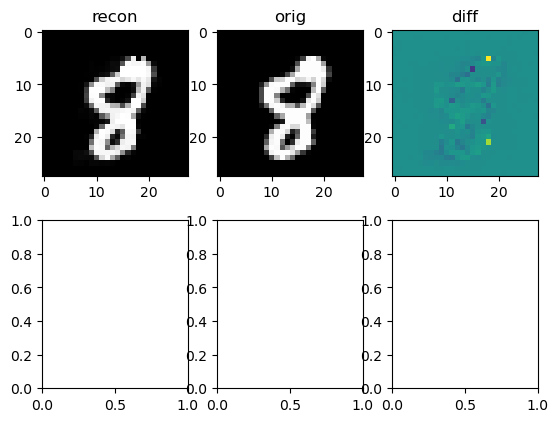

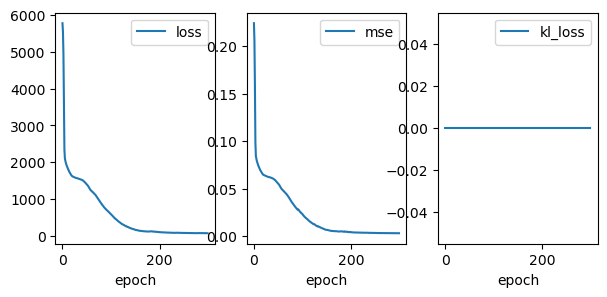

100% (300 of 300) |######################| Elapsed Time: 0:01:36 Time:  0:01:36


In [19]:
# Loss
l2loss    = nn.MSELoss(reduction="sum")

# Model and optimisers
model = Autoencoder(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Train and visualise
train_model(model, optimizer, l2loss, train_loader, nepochs, vis_frequency=100)

# Adaptive Weiner Loss 1D

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 300) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.23124760389328003, 'train_loss': 22.57193374633789, 'train_kl_loss': 0.0}
 argidx T, v:  783 626


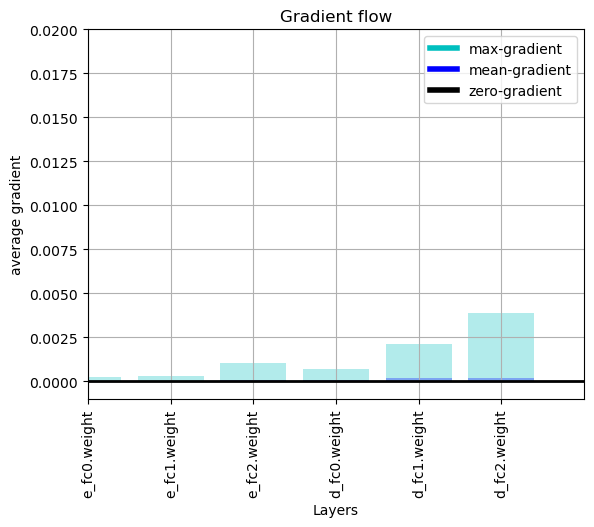

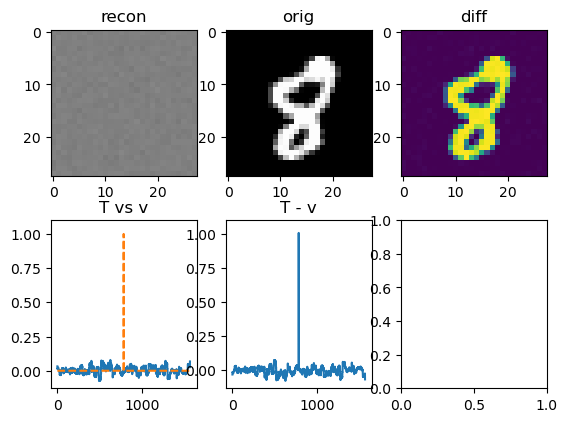

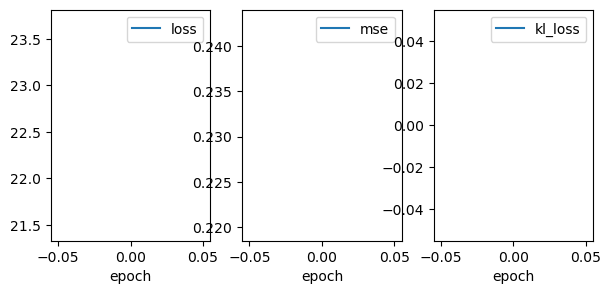

 33% (100 of 300) |#######               | Elapsed Time: 0:04:41 ETA:   0:09:24


 {'epoch': 100, 'train_mse': 0.014157302677631378, 'train_loss': 4.550445556640625, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


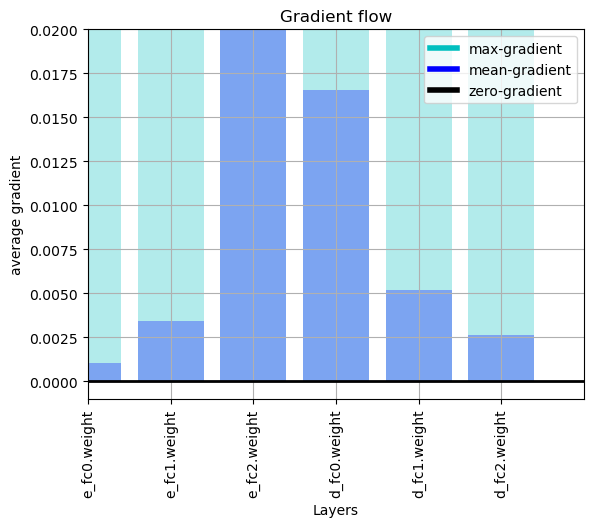

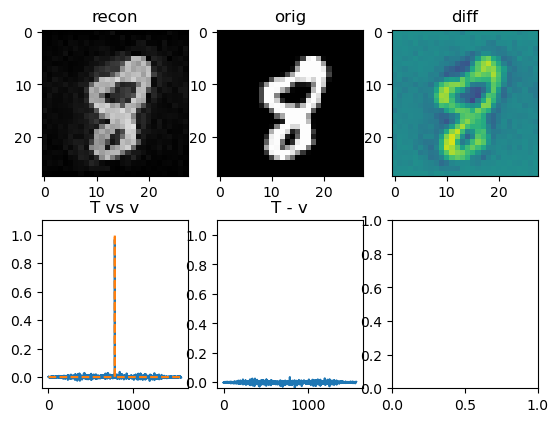

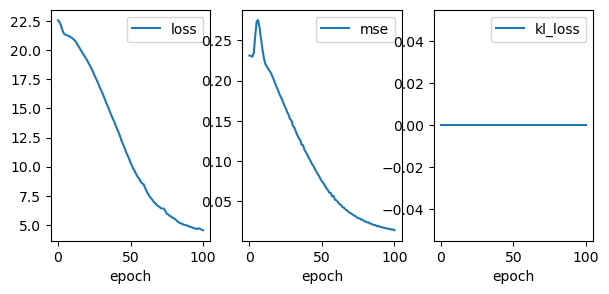

 66% (200 of 300) |##############        | Elapsed Time: 0:09:23 ETA:   0:04:43


 {'epoch': 200, 'train_mse': 0.007076866924762726, 'train_loss': 3.939263343811035, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


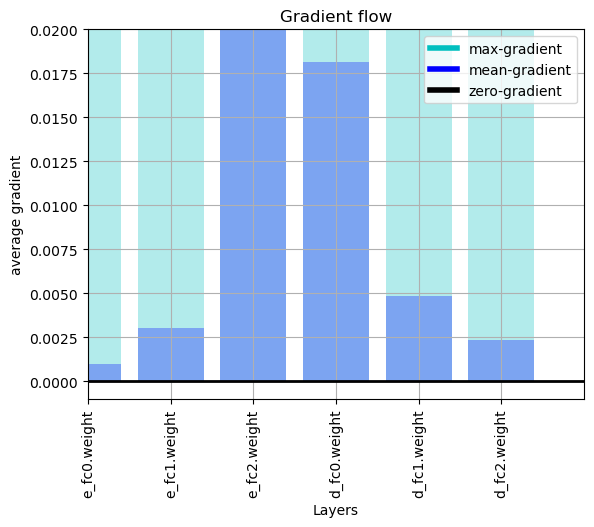

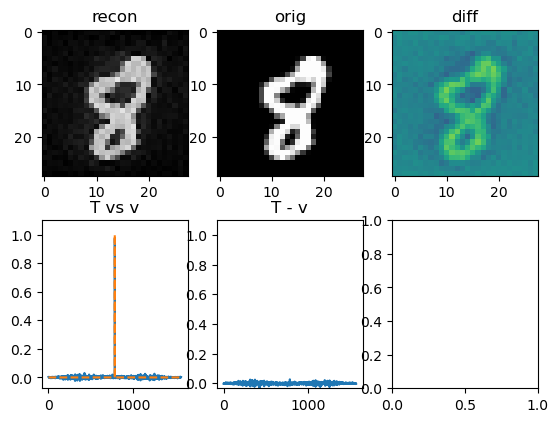

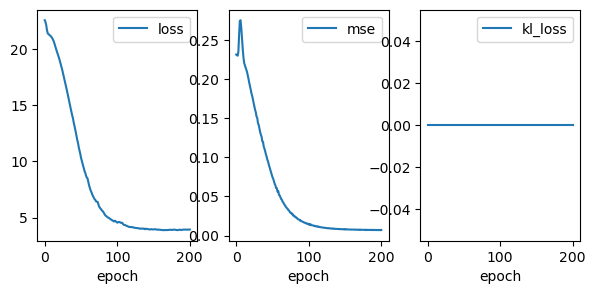

 99% (299 of 300) |##################### | Elapsed Time: 0:14:04 ETA:   0:00:02


 {'epoch': 299, 'train_mse': 0.006534166168421507, 'train_loss': 3.80336856842041, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


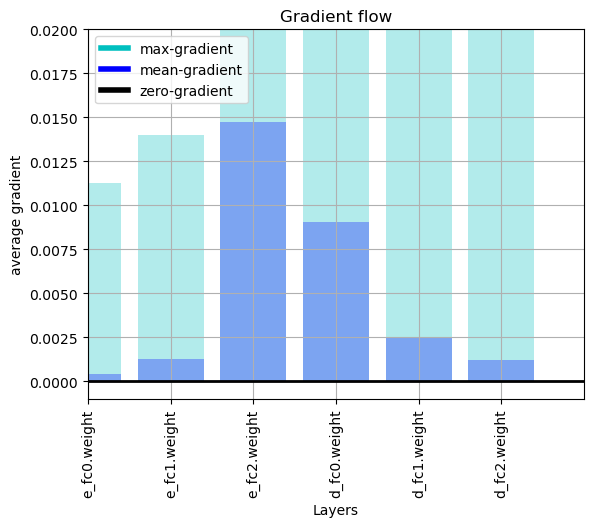

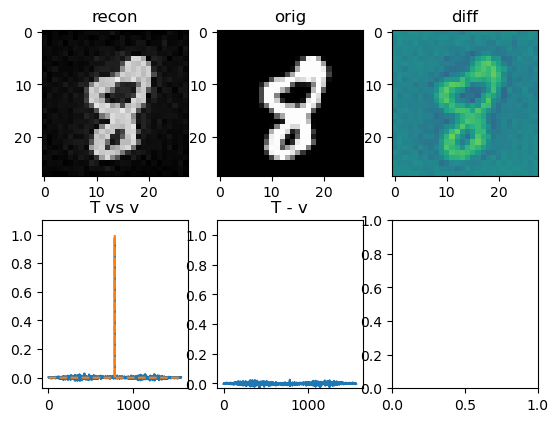

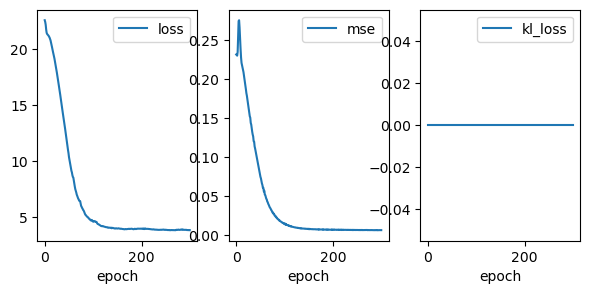

100% (300 of 300) |######################| Elapsed Time: 0:14:05 Time:  0:14:05


In [5]:
# Loss
awi1D    = AWLoss1D(reduction="sum", std=1e-4, store_filters=True, alpha=0.02)

# Model and optimisers
model = Autoencoder(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Train and visualise
train_model(model, optimizer, awi1D, train_loader, nepochs, vis_frequency=100)

# Adaptive Weiner Loss 2D

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 300) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.230636864900589, 'train_loss': 22.6024169921875, 'train_kl_loss': 0.0}
 argidx T, v:  1512 752


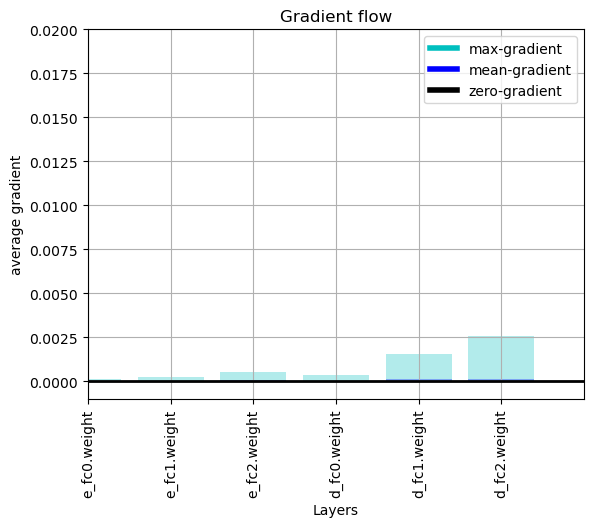

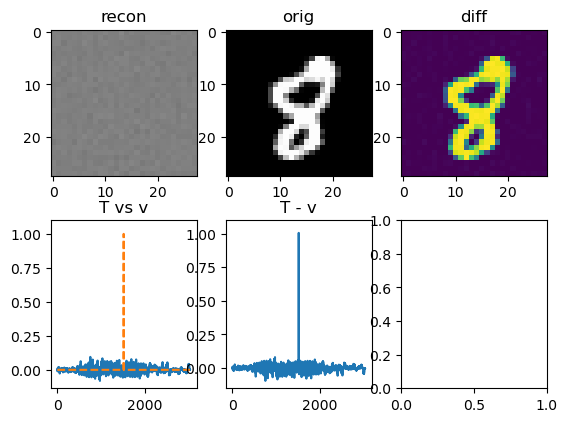

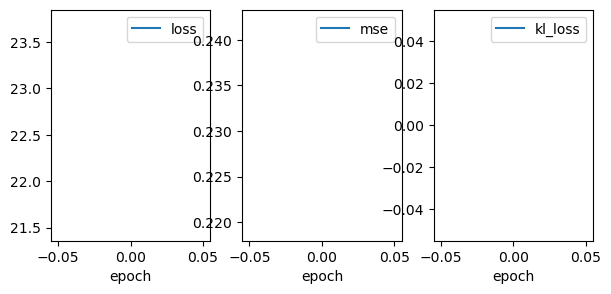

 33% (100 of 300) |#######               | Elapsed Time: 0:10:21 ETA:   0:20:47


 {'epoch': 100, 'train_mse': 0.01387159712612629, 'train_loss': 5.247060775756836, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


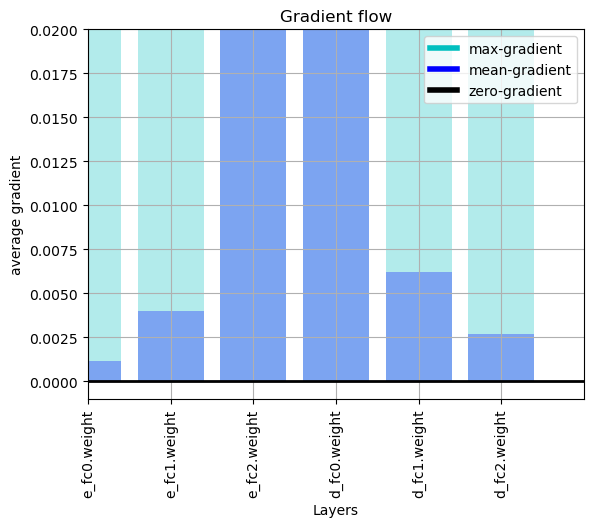

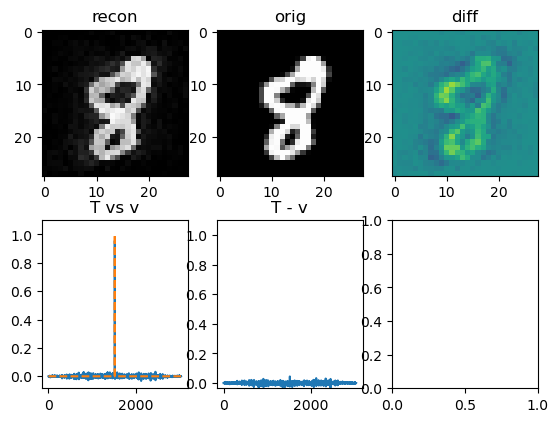

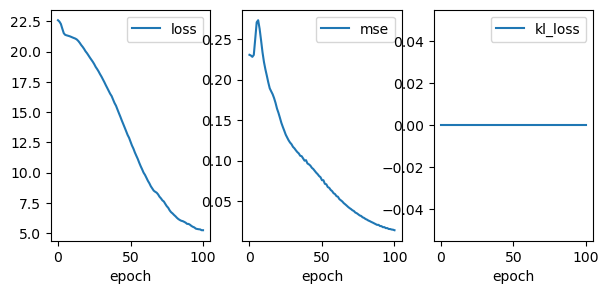

 66% (200 of 300) |##############        | Elapsed Time: 0:20:46 ETA:   0:10:19


 {'epoch': 200, 'train_mse': 0.005058598704636097, 'train_loss': 4.31473445892334, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


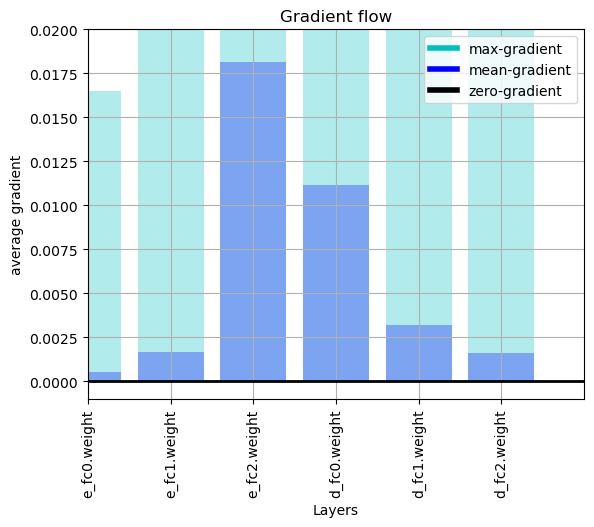

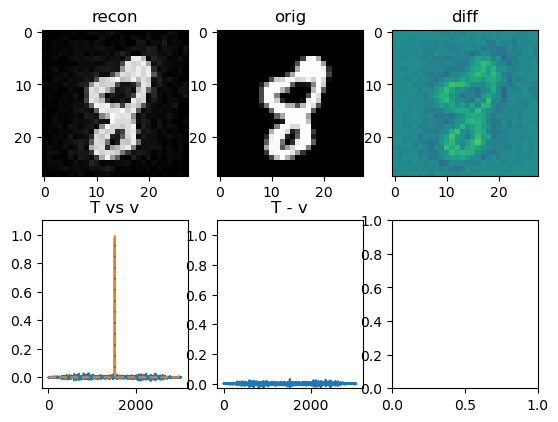

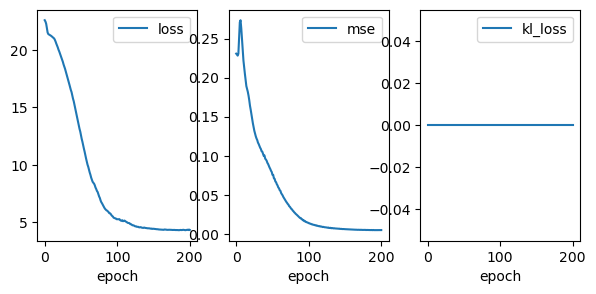

 99% (299 of 300) |##################### | Elapsed Time: 0:31:04 ETA:   0:00:06


 {'epoch': 299, 'train_mse': 0.004541624337434769, 'train_loss': 4.190699577331543, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


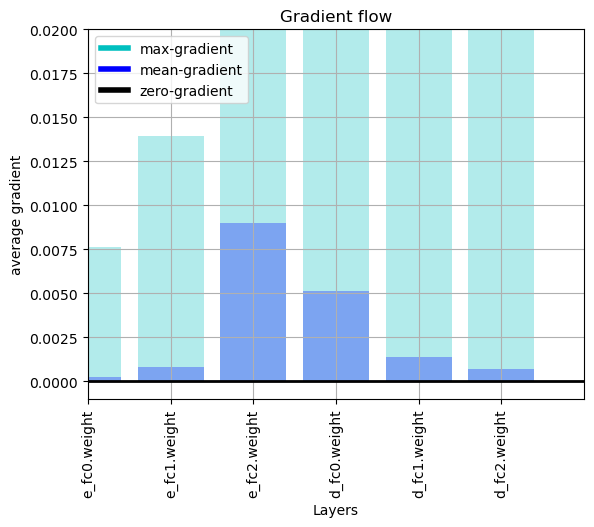

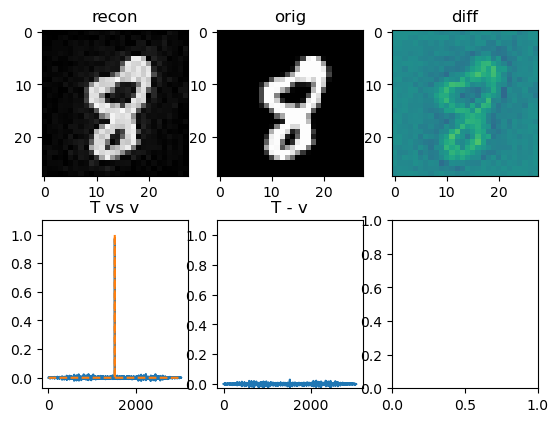

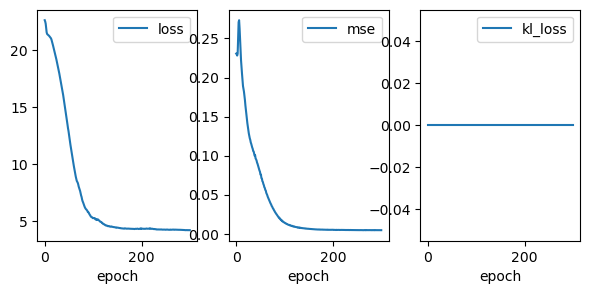

100% (300 of 300) |######################| Elapsed Time: 0:31:05 Time:  0:31:05


In [10]:
# Loss
awi2D    = AWLoss2D(reduction="sum", std=1e-4, store_filters=True, alpha=0.02)

# Model and optimisers
model = Autoencoder(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Train and visualise
train_model(model, optimizer, awi2D, train_loader, nepochs, vis_frequency=100)